In [5]:
# librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.basemap import Basemap


import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults

In [6]:
df = pd.read_csv('meteorite-landings.csv')
df.head()

name   id nametype     recclass      mass  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong               GeoLocation  
0    6.08333     (50.775000, 6.083330)  
1   10.23333    (56.183330, 10.233330)  
2 -113.00000  (54.216670, -113.000000)  
3  -99.90000   (16.883330, -99.900000)  
4  -64.95000  (-33.166670, -64.950000)

In [7]:
df.shape

(45716, 10)

In [8]:
df.dtypes

name            object
id               int64
nametype        object
recclass        object
mass           float64
fall            object
year           float64
reclat         float64
reclong        float64
GeoLocation     object
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
name           45716 non-null object
id             45716 non-null int64
nametype       45716 non-null object
recclass       45716 non-null object
mass           45585 non-null float64
fall           45716 non-null object
year           45428 non-null float64
reclat         38401 non-null float64
reclong        38401 non-null float64
GeoLocation    38401 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


# Cleaning

In [10]:
df.isna().sum()

name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

### Year 

In [11]:
#filter to drop invalid values
df = df[(df.year >=860) & (df.year <=2016)]
#transform year (float to int)
df['year'] = pd.to_numeric(df.year,downcast='integer')

### Mass

In [12]:
#drop NaN
df = df[np.isfinite(df['mass'])]

### Longitude Lattitude

In [13]:
#filter to drop invalid values
df = df[(df.reclat != 0.0) & (df.reclong != 0.0)]
df = df[(df.reclong <=180) & (df.reclong >=-180)]

### Fall

In [14]:
df.fall.value_counts(normalize=True)

Found    0.966472
Fell     0.033528
Name: fall, dtype: float64

In [15]:
df = pd.get_dummies(df, columns=['fall'])

In [16]:
df.head()

name   id nametype     recclass      mass  year    reclat    reclong  \
0    Aachen    1    Valid           L5      21.0  1880  50.77500    6.08333   
1    Aarhus    2    Valid           H6     720.0  1951  56.18333   10.23333   
2      Abee    6    Valid          EH4  107000.0  1952  54.21667 -113.00000   
3  Acapulco   10    Valid  Acapulcoite    1914.0  1976  16.88333  -99.90000   
4   Achiras  370    Valid           L6     780.0  1902 -33.16667  -64.95000   

                GeoLocation  fall_Fell  fall_Found  
0     (50.775000, 6.083330)          1           0  
1    (56.183330, 10.233330)          1           0  
2  (54.216670, -113.000000)          1           0  
3   (16.883330, -99.900000)          1           0  
4  (-33.166670, -64.950000)          1           0

# Descriptive stats and visualisation

In [17]:
df.corr()

id      mass      year    reclat   reclong  fall_Fell  \
id          1.000000 -0.014712  0.238671  0.056363 -0.183254  -0.053076   
mass       -0.014712  1.000000 -0.124215  0.036230 -0.027062   0.007814   
year        0.238671 -0.124215  1.000000 -0.229160  0.197239  -0.508986   
reclat      0.056363  0.036230 -0.229160  1.000000 -0.534294   0.310099   
reclong    -0.183254 -0.027062  0.197239 -0.534294  1.000000  -0.118656   
fall_Fell  -0.053076  0.007814 -0.508986  0.310099 -0.118656   1.000000   
fall_Found  0.053076 -0.007814  0.508986 -0.310099  0.118656  -1.000000   

            fall_Found  
id            0.053076  
mass         -0.007814  
year          0.508986  
reclat       -0.310099  
reclong       0.118656  
fall_Fell    -1.000000  
fall_Found    1.000000

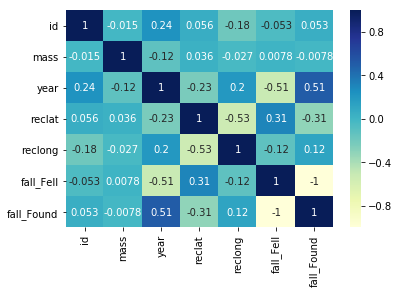

'\nit seems a positive correlation between year & found \n    0.51 : weak correlation\n\nbut a nagative correlation between year & fall\n    - 0.51 : weak correlation\n\nmass ? no correlation after remove outliers\n'

In [18]:
sns.heatmap(df.corr(),cmap="YlGnBu",annot=True)
plt.show()

'''
it seems a positive correlation between year & found 
    0.51 : weak correlation

but a nagative correlation between year & fall
    - 0.51 : weak correlation

mass ? no correlation after remove outliers
'''

### Mass

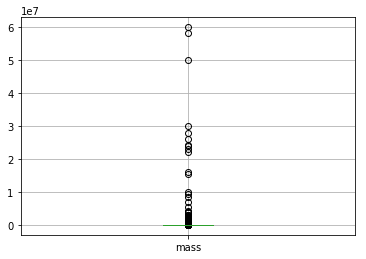

In [19]:
df.boxplot('mass')

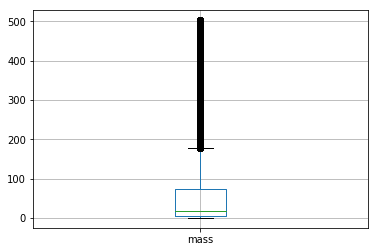

In [20]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
remove_outlier(df,'mass').boxplot('mass')

### Fell & Found

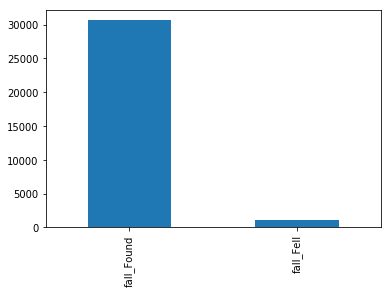

In [21]:
df[['fall_Found','fall_Fell']].agg('sum').plot.bar()

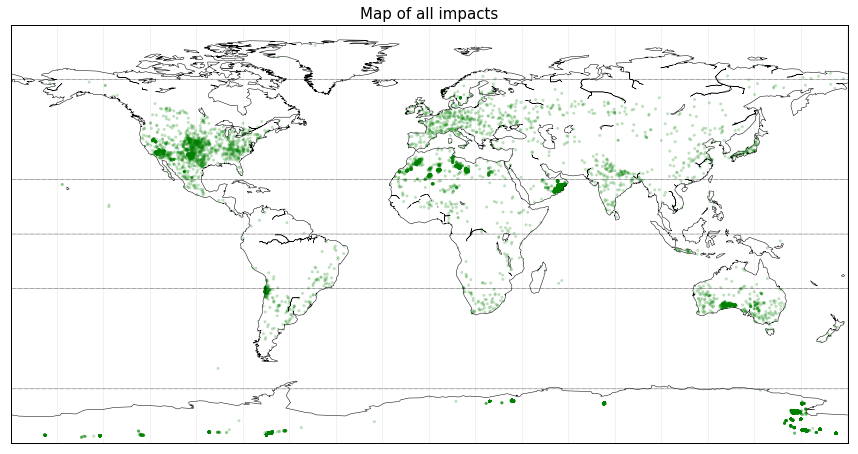

In [22]:
# MAP OF ALL IMPACTS
fig, ax = plt.subplots(figsize = (15, 10))
map = Basemap(projection='cyl')
map.drawmapboundary(fill_color='w')
map.drawcoastlines(linewidth=0.5)
map.drawmeridians(range(0, 360, 20),linewidth=0.1)
map.drawparallels([-66.56083,-23.5,0.0,23.5,66.56083], linewidth=0.6) 
#plotting equator and tropics and polar circles

x1, y1 = map(df.reclong,df.reclat)

map.scatter(x1, y1, marker='.',alpha=0.25,c='green',edgecolor='None')
plt.title('Map of all impacts', fontsize=15)
plt.show()

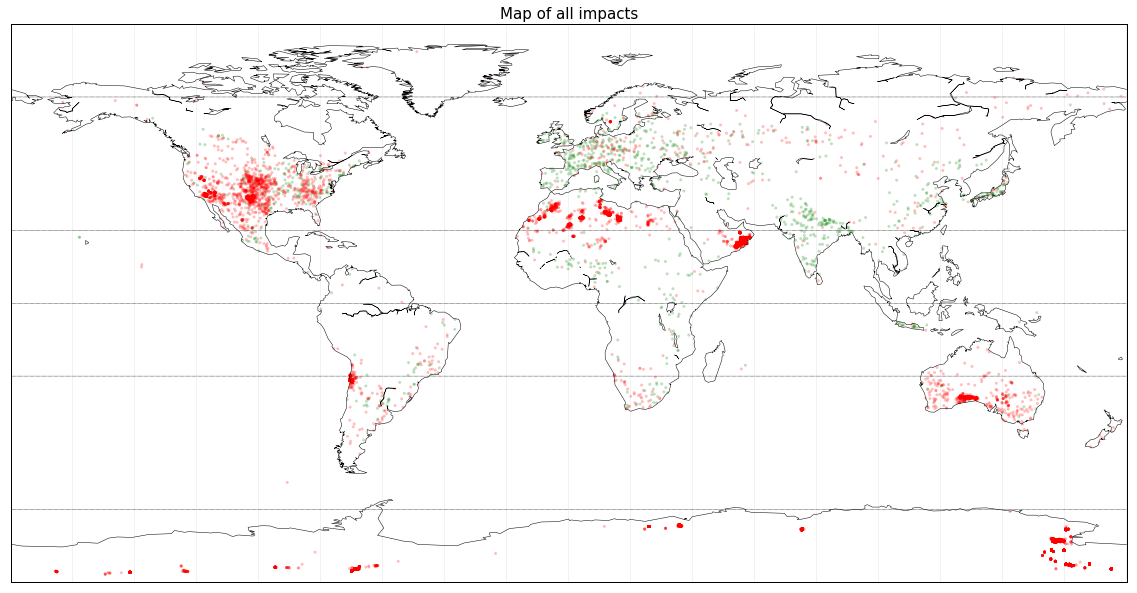

In [23]:
# MAP OF FOUND OR FELL METEORITES
fig, ax = plt.subplots(figsize = (20, 15))
map = Basemap(projection='cyl')
map.drawmapboundary(fill_color='w')
map.drawcoastlines(linewidth=0.5)
map.drawmeridians(range(0, 360, 20),linewidth=0.1)
map.drawparallels([-66.56083,-23.5,0.0,23.5,66.56083], linewidth=0.6) 
#plotting equator and tropics and polar circles

x1, y1 = map(df[df.fall_Fell == 1].reclong,df[df.fall_Fell == 1].reclat)
map.scatter(x1, y1, marker='.',alpha=0.25,c='green',edgecolor='None')

x1, y1 = map(df[df.fall_Found == 1].reclong,df[df.fall_Found == 1].reclat)
map.scatter(x1, y1, marker='.',alpha=0.25,c='red',edgecolor='None')
#plt.legend()
plt.title('Map of all impacts', fontsize=15)
plt.show()

### mass 

In [24]:
#group mass from = https://en.wikipedia.org/wiki/Meteorite_classification
#dfmass = df.copy()

In [25]:
df.recclass.replace(to_replace=['Acapulcoite', 'Acapulcoite/Lodranite', 
                                    'Acapulcoite/lodranite','Lodranite','Lodranite-an',
                                    'Winonaite','Achondrite-prim'],
                    value='Achondrite_prim',inplace=True)

In [26]:
df.recclass.replace(to_replace=['Angrite', 'Aubrite','Aubrite-an','Ureilite',
                                     'Ureilite-an','Ureilite-pmict','Brachinite','Diogenite',
                                     'Diogenite-an', 'Diogenite-olivine', 'Diogenite-pm',
                                     'Eucrite', 'Eucrite-Mg rich', 'Eucrite-an', 'Eucrite-br',
                                     'Eucrite-cm','Eucrite-mmict', 'Eucrite-pmict',
                                     'Eucrite-unbr','Howardite'],
                         value='Achondrite_aste',inplace=True)

In [27]:
df.recclass.replace(to_replace=['Lunar', 'Lunar (anorth)', 'Lunar (bas. breccia)',
                                    'Lunar (bas/anor)', 'Lunar (bas/gab brec)', 
                                    'Lunar (basalt)','Lunar (feldsp. breccia)', 
                                    'Lunar (gabbro)', 'Lunar (norite)'],
                        value='Lunar',inplace=True)

In [28]:
df.recclass.replace(to_replace=['Martian', 'Martian (OPX)','Martian (chassignite)',
                                    'Martian (nakhlite)','Martian (shergottite)'],
                        value='Martian',inplace=True)

In [29]:
df.recclass.replace(to_replace=['C','C2','C4','C4/5','C6','C1-ung', 'C1/2-ung','C2-ung',
                                    'C3-ung', 'C3/4-ung','C4-ung','C5/6-ung','CB', 'CBa',
                                    'CBb', 'CH/CBb', 'CH3', 'CH3 ', 'CI1', 'CK', 'CK3',
                                    'CK3-an', 'CK3.8', 'CK3/4', 'CK4', 'CK4-an', 'CK4/5',
                                    'CK5','CK5/6', 'CK6', 'CM', 'CM-an', 'CM1', 'CM1/2',
                                    'CM2', 'CM2-an','CO3', 'CO3 ', 'CO3.0', 'CO3.1', 'CO3.2',
                                    'CO3.3', 'CO3.4', 'CO3.5','CO3.6', 'CO3.7', 'CO3.8', 'CR',
                                    'CR-an', 'CR1', 'CR2', 'CR2-an','CV2', 'CV3', 'CV3-an'],
                        value='Chondrite_carbon',inplace=True)

In [30]:
df.recclass.replace(to_replace=['OC', 'OC3','H', 'H(5?)', 'H(?)4', 'H(L)3', 'H(L)3-an',
                                     'H-an','H-imp melt','H-melt rock', 'H-metal', 'H/L3',
                                     'H/L3-4', 'H/L3.5','H/L3.6', 'H/L3.7', 'H/L3.9', 'H/L4',
                                     'H/L4-5', 'H/L4/5', 'H/L5','H/L6', 'H/L6-melt rock',
                                     'H/L~4', 'H3', 'H3 ', 'H3-4', 'H3-5','H3-6', 'H3-an',
                                     'H3.0', 'H3.0-3.4', 'H3.1', 'H3.10', 'H3.2','H3.2-3.7',
                                     'H3.2-6', 'H3.2-an', 'H3.3', 'H3.4', 'H3.4-5','H3.4/3.5',
                                     'H3.5', 'H3.5-4', 'H3.6', 'H3.6-6', 'H3.7', 'H3.7-5',
                                     'H3.7-6', 'H3.7/3.8', 'H3.8', 'H3.8-4', 'H3.8-5', 'H3.8-6',
                                     'H3.8-an', 'H3.8/3.9', 'H3.8/4', 'H3.9', 'H3.9-5', 
                                     'H3.9-6','H3.9/4', 'H3/4', 'H4', 'H4 ', 'H4(?)', 'H4-5',
                                     'H4-6', 'H4-an','H4/5', 'H4/6', 'H5', 'H5 ', 'H5-6', 
                                     'H5-7', 'H5-an','H5-melt breccia', 'H5/6', 'H6', 'H6 ',
                                     'H6-melt breccia', 'H6/7','H7', 'H?','H~4', 'H~4/5', 'H~5',
                                     'H~6','L', 'L(?)3','L(H)3', 'L(LL)3', 'L(LL)3.05',
                                     'L(LL)3.5-3.7', 'L(LL)5', 'L(LL)6','L(LL)~4', 'L-imp melt',
                                     'L-melt breccia', 'L-melt rock', 'L-metal','L/LL',
                                     'L/LL(?)3', 'L/LL-melt rock', 'L/LL3', 'L/LL3-5',
                                     'L/LL3-6','L/LL3.10', 'L/LL3.2', 'L/LL3.4', 'L/LL3.5',
                                     'L/LL3.6/3.7', 'L/LL4','L/LL4-6', 'L/LL4/5', 'L/LL5',
                                     'L/LL5-6', 'L/LL5/6', 'L/LL6','L/LL6-an', 'L/LL~4',
                                     'L/LL~5', 'L/LL~6', 'L3', 'L3-4', 'L3-5','L3-6', 'L3-7',
                                     'L3.0', 'L3.0-3.7', 'L3.0-3.9', 'L3.05', 'L3.1','L3.10',
                                     'L3.2', 'L3.2-3.5', 'L3.2-3.6', 'L3.3', 'L3.3-3.5',
                                     'L3.3-3.6', 'L3.3-3.7', 'L3.4', 'L3.4-3.7', 'L3.5',
                                     'L3.5-3.7','L3.5-3.8', 'L3.5-3.9', 'L3.5-5', 'L3.6',
                                     'L3.6-4', 'L3.7','L3.7-3.9', 'L3.7-4', 'L3.7-6',
                                     'L3.7/3.8', 'L3.8', 'L3.8-5','L3.8-6', 'L3.8-an', 'L3.9',
                                     'L3.9-5', 'L3.9-6', 'L3.9/4', 'L3/4','L4', 'L4 ', 'L4-5',
                                     'L4-6', 'L4-an', 'L4-melt rock', 'L4/5', 'L5','L5 ',
                                     'L5-6', 'L5-7', 'L5/6', 'L6', 'L6 ', 'L6-melt breccia',
                                     'L6-melt rock', 'L6/7', 'L7', 'LL', 'LL(L)3', 
                                     'LL-melt rock', 'LL3','LL3-4', 'LL3-5', 'LL3-6', 'LL3.0',
                                     'LL3.00', 'LL3.1', 'LL3.1-3.5','LL3.10', 'LL3.15', 'LL3.2',
                                     'LL3.3', 'LL3.4', 'LL3.5', 'LL3.6','LL3.7', 'LL3.7-6',
                                     'LL3.8', 'LL3.8-6', 'LL3.9', 'LL3.9/4', 'LL3/4','LL4',
                                     'LL4-5', 'LL4-6', 'LL4/5', 'LL4/6', 'LL5', 'LL5-6',
                                     'LL5-7','LL5/6', 'LL6', 'LL6 ', 'LL6(?)', 'LL6/7', 'LL7',
                                     'LL7(?)','LL<3.5', 'LL~3', 'LL~4', 'LL~4/5', 'LL~5',
                                     'LL~6','L~3', 'L~4', 'L~5', 'L~6','Relict H','Relict OC'],
                         value='Chondrite_ordin',inplace=True)

In [31]:
df.recclass.replace(to_replace=['EH','EH-imp melt', 'EH3', 'EH3/4-an', 'EH4', 'EH4/5',
                                     'EH5', 'EH6','EH6-an', 'EH7', 'EH7-an', 'EL3', 'EL3/4',
                                     'EL4', 'EL4/5', 'EL5','EL6', 'EL6 ', 'EL6/7', 'EL7','E',
                                     'E3','E4', 'E5','E6'],
                         value='Chondrite_enst',inplace=True)

In [32]:
df.recclass.replace(to_replace=['K', 'K3','R', 'R3', 'R3-4', 'R3-5', 'R3-6', 'R3.4', 
                                    'R3.5-6','R3.6', 'R3.7', 'R3.8', 'R3.8-5', 'R3.8-6', 'R3.9',
                                    'R3/4', 'R4','R4/5', 'R5', 'R6'],
                        value='Chondrite_other',inplace=True)

In [33]:
df.recclass.replace(to_replace=['Pallasite', 'Pallasite, PES','Pallasite, PMG',
                                    'Pallasite, PMG-an', 'Pallasite, ungrouped','Pallasite?'],
                        value='Pallasite',inplace=True)

In [34]:
df.recclass.replace(to_replace=['Mesosiderite', 'Mesosiderite-A','Mesosiderite-A1',
                                    'Mesosiderite-A2', 'Mesosiderite-A3','Mesosiderite-A3/4',
                                    'Mesosiderite-A4', 'Mesosiderite-B','Mesosiderite-B1',
                                    'Mesosiderite-B2', 'Mesosiderite-B4','Mesosiderite-C',
                                    'Mesosiderite-C2', 'Mesosiderite-an','Mesosiderite?'],
                        value='Mesosiderite',inplace=True)

In [35]:
df.recclass.replace(to_replace=['Iron, IC', 'Iron, IC-an', 'Iron, IIAB', 'Iron, IIAB-an',
                                    'Iron, IIC', 'Iron, IID', 'Iron, IID-an','Iron, IIF', 
                                    'Iron, IIG','Iron, IIIAB', 'Iron, IIIAB-an', 'Iron, IIIAB?',
                                    'Iron, IIIE','Iron, IIIE-an', 'Iron, IIIF', 'Iron, IVA',
                                    'Iron, IVA-an','Iron, IVB'],
                        value='Magmatic',inplace=True)

In [36]:
df.recclass.replace(to_replace=['Iron, IAB complex', 'Iron, IAB-MG','Iron, IAB-an',
                                    'Iron, IAB-sHH','Iron, IAB-sHL', 'Iron, IAB-sLH',
                                    'Iron, IAB-sLL', 'Iron, IAB-sLM','Iron, IAB-ung',
                                    'Iron, IAB?','Iron, IIE','Iron, IIE-an', 'Iron, IIE?'],
                        value='Non_magmatic',inplace=True)

In [37]:
df.recclass.replace(to_replace=['Iron','Iron?','Relict iron','Chondrite-fusion crust',
                                    'Fusion crust','Impact melt breccia','Enst achon-ung',
                                    'Iron, ungrouped','Stone-uncl', 'Stone-ung','Unknown',
                                    'Achondrite-ung','Chondrite-ung','Enst achon','E-an',
                                    'E3-an',  'E5-an'],
                        value='Unknown-Ungrouped',inplace=True)



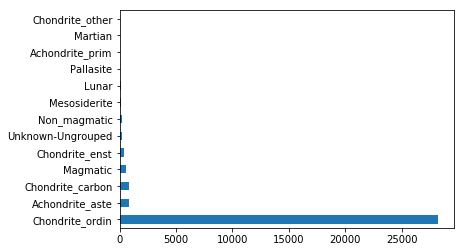

In [38]:
df.recclass.value_counts().plot.barh()

In [39]:
df.head()

name   id nametype         recclass      mass  year    reclat  \
0    Aachen    1    Valid  Chondrite_ordin      21.0  1880  50.77500   
1    Aarhus    2    Valid  Chondrite_ordin     720.0  1951  56.18333   
2      Abee    6    Valid   Chondrite_enst  107000.0  1952  54.21667   
3  Acapulco   10    Valid  Achondrite_prim    1914.0  1976  16.88333   
4   Achiras  370    Valid  Chondrite_ordin     780.0  1902 -33.16667   

     reclong               GeoLocation  fall_Fell  fall_Found  
0    6.08333     (50.775000, 6.083330)          1           0  
1   10.23333    (56.183330, 10.233330)          1           0  
2 -113.00000  (54.216670, -113.000000)          1           0  
3  -99.90000   (16.883330, -99.900000)          1           0  
4  -64.95000  (-33.166670, -64.950000)          1           0

dfrec = df[df.recclass == 'Chondrite_ordin']
dfrec.recclass.value_counts()

# logistic regression 
possible to predict where the meteorits found depending to year

In [40]:
dftest = df.copy()
dflog = dftest.copy()

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
#df1 = pd.get_dummies(df1, columns=['recclass'])

In [43]:
dflog.head()

name   id nametype         recclass      mass  year    reclat  \
0    Aachen    1    Valid  Chondrite_ordin      21.0  1880  50.77500   
1    Aarhus    2    Valid  Chondrite_ordin     720.0  1951  56.18333   
2      Abee    6    Valid   Chondrite_enst  107000.0  1952  54.21667   
3  Acapulco   10    Valid  Achondrite_prim    1914.0  1976  16.88333   
4   Achiras  370    Valid  Chondrite_ordin     780.0  1902 -33.16667   

     reclong               GeoLocation  fall_Fell  fall_Found  
0    6.08333     (50.775000, 6.083330)          1           0  
1   10.23333    (56.183330, 10.233330)          1           0  
2 -113.00000  (54.216670, -113.000000)          1           0  
3  -99.90000   (16.883330, -99.900000)          1           0  
4  -64.95000  (-33.166670, -64.950000)          1           0

In [44]:
dflog.columns

Index(['name', 'id', 'nametype', 'recclass', 'mass', 'year', 'reclat',
       'reclong', 'GeoLocation', 'fall_Fell', 'fall_Found'],
      dtype='object')

In [45]:
dflog = dftest.drop('fall_Fell',axis=1).drop('recclass',axis=1).drop(
    'nametype',axis=1).drop('id',axis=1).drop('name',axis=1)
dflog[df.fall_Found == 0].shape

(1063, 6)

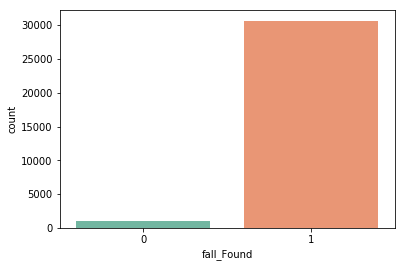

In [46]:
sns.countplot(x='fall_Found',data=dflog,palette="Set2")

This is a count plot that shows the number of meteorite who found which is our target variable. 

In [47]:
from sklearn.model_selection import train_test_split
dflog_test = dflog.copy()
X_train, X_test, y_train, y_test = train_test_split(dflog_test.drop('fall_Found',axis=1), 
                                                    dflog_test['fall_Found'], test_size=0.30, 
                                                    random_state=101)

In [48]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: '(-72.774444, 75.321667)'

In [49]:
y_train.value_counts()

1    21444
0      749
Name: fall_Found, dtype: int64

In [50]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt

In [51]:
X_train, X_test, y_train, y_test = train_test_split(dflog_test.drop('fall_Found',axis=1), 
                                                    dflog_test['fall_Found'], test_size=0.30, 
                                                    random_state=101)

In [86]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
#predictions = logmodel.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: '(-10.059440, 33.395000)'

In [53]:
dfsamp = dflog.copy()

In [54]:
dfsamp.fall_Found.value_counts()

1    30642
0     1063
Name: fall_Found, dtype: int64

In [55]:
dfsamp = dfsamp[dfsamp['fall_Found'] == 1]


In [56]:
dfsamp = dfsamp.sample(n=3500, weights='fall_Found', random_state=1)

In [57]:
dfsamp.shape

(3500, 6)

In [58]:
dfsamp2 = dflog.copy()

In [59]:
dfsamp2.fall_Found.value_counts()

1    30642
0     1063
Name: fall_Found, dtype: int64

In [60]:
dfsamp2 = dfsamp2[dfsamp2['fall_Found'] == 0]


In [61]:
dfsamp = dfsamp.append(dfsamp2)

In [62]:
dfsamp.fall_Found.value_counts()

1    3500
0    1063
Name: fall_Found, dtype: int64

In [63]:
dfsamp = dfsamp.reset_index()
dfsamp = dfsamp.drop('index',axis=1)

In [64]:
from sklearn.utils import shuffle
dfsamp = shuffle(dfsamp)

In [65]:
X = dfsamp # Features
y = dfsamp.fall_Found # Target variable

In [66]:
X_train,X_test = train_test_split(dfsamp,test_size=0.3, random_state=0)
print(len(X_train), len(X_test))

3194 1369


In [67]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel_fit = logmodel.fit(X_train,X_test)
#predictions = logmodel.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: '(-10.059440, 33.395000)'

In [68]:

X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

NameError: name 'data_final_vars' is not defined

In [69]:
import statsmodels.api as sm
logit_model=sm.Logit(X_train.fall_Found,X_train.iloc[:,:-1])
result=logit_model.fit()
print(result.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [70]:
X_train.year.value_counts()

1979    238
1988    178
2000    141
2003    140
1999    137
1990    134
1986    115
2001    108
2006    103
2002    100
1997     98
1993     79
1991     68
1987     67
1994     65
1995     54
1984     52
1996     48
2011     47
1981     43
1975     39
1998     39
1974     39
1985     38
1992     37
1983     34
2004     32
1977     30
2008     27
2009     25
       ... 
1490      1
1830      1
1621      1
1854      1
1801      1
1931      1
1885      1
1849      1
1847      1
1839      1
1833      1
1827      1
1819      1
1817      1
1813      1
1805      1
1795      1
1862      1
1785      1
1775      1
1751      1
1741      1
1671      1
1637      1
1583      1
1491      1
1399      1
1894      1
1870      1
860       1
Name: year, Length: 225, dtype: int64

In [71]:
def gr_year(i):
    if i >= 2010 :
        i = '2010_2020'
    elif (i >= 1980) & (i <= 1989):
        i = "1980s"
    elif (i >= 1990) & (i <= 1999):
        i = "1990s"
    elif (i >= 2000) & (i <= 2009) :
        i = "2000s"
    elif i < 1980 : 
        i = 'bf_1970'
    return i

In [72]:
dfsamp['year'] = dfsamp['year'].apply(lambda x: gr_year(x))

In [73]:
dfsamp = pd.get_dummies(dfsamp, columns=['year'])

In [74]:
dfsamp = dfsamp.drop('year_bf_1970',axis=1)

In [75]:
dfsamp

mass     reclat     reclong                GeoLocation  fall_Found  \
3810   4162.00  12.850000   11.033330     (12.850000, 11.033330)           0   
3707     78.40  35.950000  -97.583330    (35.950000, -97.583330)           0   
1492    591.00  27.151330   16.045000     (27.151330, 16.045000)           1   
1082      4.61 -71.500000   35.666670    (-71.500000, 35.666670)           1   
3808    380.00  27.883330   68.533330     (27.883330, 68.533330)           0   
2551      8.58 -86.366670  -70.000000   (-86.366670, -70.000000)           1   
3689   6000.00  53.700000   30.100000     (53.700000, 30.100000)           0   
840      25.61 -85.633330  -68.700000   (-85.633330, -68.700000)           1   
65        3.60 -84.575870  162.566600   (-84.575870, 162.566600)           1   
2425     13.10 -76.688060  159.360840   (-76.688060, 159.360840)           1   
3995   2800.00  47.083330    1.750000      (47.083330, 1.750000)           0   
159     439.40 -84.266110  161.316670   (-84.266110, 161.316670)           1   
1040   2576.00  34.533330 -101.183330   (34.533330, -101.183330)           1   
60        0.84 -72.775000   75.339722    (-72.775000, 75.339722)           1   
2180    328.29 -72.000000   26.000000    (-72.000000, 26.000000)           1   
4098   6380.00  35.568330  133.220000    (35.568330, 133.220000)           0   
3405    869.00  27.666670    4.283330      (27.666670, 4.283330)           1   
4145  23200.00  13.733330  100.083330    (13.733330, 100.083330)           0   
2082     26.11 -72.952750  160.498330   (-72.952750, 160.498330)           1   
4037   3500.00  47.850000    0.483330      (47.850000, 0.483330)           0   
2267     18.00 -30.366670  130.083330   (-30.366670, 130.083330)           1   
2653     19.10 -76.283410  156.462790   (-76.283410, 156.462790)           1   
1288     14.00 -79.683330  159.750000   (-79.683330, 159.750000)           1   
4449   3000.00  14.250000    1.533330      (14.250000, 1.533330)           0   
586     341.00  18.962170   54.189670     (18.962170, 54.189670)           1   
4558   2900.00  39.666670  122.983330    (39.666670, 122.983330)           0   
771       2.55 -72.952030  160.509390   (-72.952030, 160.509390)           1   
48       18.00 -76.267290  156.442190   (-76.267290, 156.442190)           1   
182      11.90 -76.275950  156.469860   (-76.275950, 156.469860)           1   
3815    670.00  52.200000    6.866670      (52.200000, 6.866670)           0   
...        ...        ...         ...                        ...         ...   
609       1.27 -72.784440   75.280280    (-72.784440, 75.280280)           1   
818      99.10 -84.000000  168.000000   (-84.000000, 168.000000)           1   
3413  13000.00  36.850000  -82.450000    (36.850000, -82.450000)           1   
2555     21.90 -86.366670  -70.000000   (-86.366670, -70.000000)           1   
3229      1.60 -71.500000   35.666670    (-71.500000, 35.666670)           1   
4361  20000.00  21.683890   79.500830     (21.683890, 79.500830)           0   
2192      3.30 -76.281980  156.427840   (-76.281980, 156.427840)           1   
2654     22.10 -84.000000  168.000000   (-84.000000, 168.000000)           1   
2837     10.50 -84.000000  168.000000   (-84.000000, 168.000000)           1   
283      83.90 -71.500000   35.666670    (-71.500000, 35.666670)           1   
4159   6189.00  47.525000   10.808330     (47.525000, 10.808330)           0   
593     569.95 -72.000000   26.000000    (-72.000000, 26.000000)           1   
2586      1.98 -71.500000   35.666670    (-71.500000, 35.666670)           1   
1628      9.16 -30.126330  127.410330   (-30.126330, 127.410330)           1   
53       11.00 -76.276200  156.359390   (-76.276200, 156.359390)           1   
2334      8.80 -76.901450  156.687380   (-76.901450, 156.687380)           1   
950      10.00 -86.716670 -141.500000  (-86.716670, -141.500000)           1   
4209   4440.00  12.900000    0.080000      (12.900000, 0.080000)           0   
247       

# Polygon

In [76]:
import geopandas as gpd

In [77]:
from shapely.geometry import Polygon

In [78]:
polygon_geom = Polygon(zip(dfsamp.reclong, dfsamp.reclat))
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
print(polygon.geometry)

0    POLYGON ((11.03333 12.85, -97.58333 35.95, 16....
Name: geometry, dtype: object


In [79]:
#polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
#polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

In [80]:
import folium
m = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(polygon).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [81]:
!pip install datapackage

  Using cached https://files.pythonhosted.org/packages/9d/83/46e4f7d7bdf3cc4fa76f0ab7e7db3a890ae1c98a88e143a7f0eae7d031be/datapackage-1.6.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9f/0d/523058d853abf76bf97057eb498efaf2b4aca433cf9c2db11a6e04c1ebb1/tabulator-1.21.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/74/64/3988d388315c1af3e24f447689dadf30edead43366fb2041cb103380b57f/cchardet-2.1.4.tar.gz
  Using cached https://files.pythonhosted.org/packages/a1/55/36de5a9c3cf6f615ddfcec5fc1b99dac393f09351ac2ffa4b18c9fbeb36b/tableschema-1.5.3-py2.py3-none-any.whl
  Complete output from command /anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-install-hkcf9u2g/cchardet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /private/var/folders/xc/6t9f4xbd23x

Failed to build cchardet
  Running setup.py install for cchardet ... error
    Complete output from command /anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-install-hkcf9u2g/cchardet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-record-x0vhtqc_/install-record.txt --single-version-externally-managed --compile:
    cythonize: ['src/cchardet/_cchardet.pyx']
    /anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-install-hkcf9u2g/cchardet/src/cchardet/_cchardet.pyx
      tree = Parsing.p_module(s, pxd, full_module_name)
    running install
    run

Command "/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-install-hkcf9u2g/cchardet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-record-x0vhtqc_/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /private/var/folders/xc/6t9f4xbd23x_54t00bpq4h0m0000gn/T/pip-install-hkcf9u2g/cchardet/


In [82]:
import requests

In [83]:
def example(latitude,longitude):
# grab some lat/long coords from wherever. For this example,
# I just opened a javascript console in the browser and ran:
#
# navigator.geolocation.getCurrentPosition(function(p) {
#   console.log(p);
# })
#
    #latitude = -84.00000 #35.1330343
    #longitude = 168.00000 #-90.0625056
# Did the geocoding request comes from a device with a
# location sensor? Must be either true or false.
    sensor = 'true'
# Hit Google's reverse geocoder directly
# NOTE: I *think* their terms state that you're supposed to
# use google maps if you use their api for anything.
    base = 
    params =.format(
lat=latitude,
lon=longitude,
sen=sensor
    )
    url = "{base}{params}".format(base=base, params=params)
    response = requests.get(url)
    return response.json()['results'][0]['address_components']

In [84]:
for i in example(dfsamp.reclat[109],dfsamp.reclong[109]) : 
    countries = []   
    countries.append(i['long_name'])
    print(countries)

['Jufra District']
['Libya']


In [85]:
 for key,val in tt:
        test = []
        if (key == 'types') & ('country' == val): 
            #test.append(['long_name'])
            print(True)

NameError: name 'tt' is not defined

In [ ]:
{k: v for k, v in ['address_components'].items() if v[0] countain and v[1] < 5}

In [ ]:
example(44.383330,-68.750000)

In [87]:
for j in range(0,4563):
    for i in example(dfsamp.reclat[j],dfsamp.reclong[j]) : 
        countries = []
        countries.append(i['long_name'])
    print(countries)

['Antarctica']
['Antarctica']
['79311']
['Antarctica']
['Libya']
['Antarctica']
['Oman']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Oman']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['92356']
['64434']
['Oman']
['Oman']
['Antarctica']
['United States']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Libya']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['5690']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Chile']
['Antarctica']
['Libya']
['Antarctica']
['Antarctica']
['Antarctica']
['78945']
['Antarctica']
['Antarctica']
['Oman']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Antarctica']
['Chile']
['79052']
['O

IndexError: list index out of range

In [ ]:
dfsamp.shape

In [ ]:
!pip install geopy

In [ ]:
dfsamp.GeoLocation